## Modules 1-6 Recap — Full Picture

Look at how far we've come:

```
Raw CSV (197,428 rows, 14 cols, nulls, corrupt values, string dates)
        ↓ Module 1: Problem framing, target engineering
        ↓ Module 2: EDA, pattern discovery  
        ↓ Module 3: Statistical proof
        ↓ Module 4: Cleaning pipeline
        ↓ Module 5: Feature engineering (25 features, best corr 0.31)
        ↓ Module 6: Leakage-free splits, scaling, saved artifacts
Production-ready dataset (133,440 train / 23,549 val / 39,248 test)
```

Every decision documented, every choice justified, every leakage trap avoided.

## Module 7 - Baseline Models

Before we touch a neural network we build **simple models first.** This is non-negotiable senior practice.

Here's why this matters so much — imagine you build a beautiful neural network, train it for hours, and get RMSE of 12 minutes. Is that good? **You have no idea without a baseline.**

If a simple linear regression gets RMSE of 11 minutes, your neural network added enormous complexity for zero gain. If linear regression gets RMSE of 18 minutes, your NN at 12 minutes is a genuine 33% improvement worth the complexity.

**Baselines give your results meaning.**

We'll build three baselines in order of complexity:

**Baseline 1 — Dummy Regressor** (predict the mean every time). This is the floor — if your model can't beat this, something is fundamentally broken.

**Baseline 2 — Linear Regression.** Tests whether linear relationships alone are sufficient. If this performs well, a neural network may be overkill.

**Baseline 3 — Random Forest.** Strong non-linear baseline. If our NN can't beat a Random Forest, the architecture needs rethinking.


In [1]:
# ===============================
# 1. Imports
# ===============================
import pandas as pd
import joblib
from pathlib import Path

# ===============================
# 2. Define data directory
# ===============================
DATA_DIR = Path("./porter_model")   

# ===============================
# 3. Load feature datasets
# ===============================
X_tr = pd.read_csv(DATA_DIR / "X_train.csv")
X_val   = pd.read_csv(DATA_DIR / "X_val.csv")
X_test_scaled  = pd.read_csv(DATA_DIR / "X_test.csv")

# ===============================
# 4. Load target datasets (log scale)
# ===============================
y_tr = pd.read_csv(DATA_DIR / "y_train.csv").squeeze()
y_val   = pd.read_csv(DATA_DIR / "y_val.csv").squeeze()
y_test  = pd.read_csv(DATA_DIR / "y_test.csv").squeeze()

# ===============================
# 5. Load raw targets (original scale)
# ===============================
y_tr_raw = pd.read_csv(DATA_DIR / "y_train_raw.csv").squeeze()
y_val_raw   = pd.read_csv(DATA_DIR / "y_val_raw.csv").squeeze()
y_test_raw  = pd.read_csv(DATA_DIR / "y_test_raw.csv").squeeze()

# ===============================
# 6. Load saved scaler
# ===============================
scaler = joblib.load(DATA_DIR / "scaler.pkl")

# ===============================
# 7. Quick sanity check (optional but professional)
# ===============================
print("Shapes:")
print("X_train:", X_tr.shape, " | y_train:", y_tr.shape)
print("X_val:", X_val.shape, " | y_val:", y_val.shape)
print("X_test:", X_test_scaled.shape, " | y_test:", y_test.shape)


Shapes:
X_train: (133440, 25)  | y_train: (133440,)
X_val: (23549, 25)  | y_val: (23549,)
X_test: (39248, 25)  | y_test: (39248,)


In [2]:
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate_model(name, y_true_log, y_pred_log, y_true_raw):
    """
    Evaluate in both log space and real minutes.
    Always evaluate what matters to the business — real minutes.
    """
    # Inverse transform predictions to real minutes
    y_pred_raw = np.expm1(y_pred_log)
    
    # Metrics in real minutes
    rmse = np.sqrt(mean_squared_error(y_true_raw, y_pred_raw))
    mae = mean_absolute_error(y_true_raw, y_pred_raw)
    
    # Also compute in log space for training diagnostics
    rmse_log = np.sqrt(mean_squared_error(y_true_log, y_pred_log))
    
    print(f"\n{'='*45}")
    print(f"Model: {name}")
    print(f"  RMSE (real minutes): {rmse:.4f}")
    print(f"  MAE  (real minutes): {mae:.4f}")
    print(f"  RMSE (log space):    {rmse_log:.4f}")
    
    return rmse, mae

In [3]:
results = {}

# ── Baseline 1: Dummy Regressor ────────────────────────────────────────
dummy = DummyRegressor(strategy='mean')
dummy.fit(X_tr, y_tr)
y_pred_dummy = dummy.predict(X_val)
rmse, mae = evaluate_model('Dummy (predict mean)', 
                            y_val, y_pred_dummy, y_val_raw)
results['Dummy'] = {'rmse': rmse, 'mae': mae}

# ── Baseline 2: Linear Regression ─────────────────────────────────────
lr = LinearRegression()
lr.fit(X_tr, y_tr)
y_pred_lr = lr.predict(X_val)
rmse, mae = evaluate_model('Linear Regression', 
                            y_val, y_pred_lr, y_val_raw)
results['LinearRegression'] = {'rmse': rmse, 'mae': mae}

# ── Baseline 3: Ridge Regression ──────────────────────────────────────
ridge = Ridge(alpha=1.0)
ridge.fit(X_tr, y_tr)
y_pred_ridge = ridge.predict(X_val)
rmse, mae = evaluate_model('Ridge Regression', 
                            y_val, y_pred_ridge, y_val_raw)
results['Ridge'] = {'rmse': rmse, 'mae': mae}


Model: Dummy (predict mean)
  RMSE (real minutes): 17.3776
  MAE  (real minutes): 12.9829
  RMSE (log space):    0.3442

Model: Linear Regression
  RMSE (real minutes): 18.5454
  MAE  (real minutes): 14.0266
  RMSE (log space):    0.3122

Model: Ridge Regression
  RMSE (real minutes): 18.5454
  MAE  (real minutes): 14.0266
  RMSE (log space):    0.3122


In [4]:
# Check linear regression coefficients
# What is it actually learning?
coef_df = pd.DataFrame({
    'feature': X_tr.columns,
    'coefficient': lr.coef_
}).sort_values('coefficient', key=abs, ascending=False)

print("Top 10 most influential features (Linear Regression):")
print(coef_df.head(10))
print("\nBottom 5 least influential:")
print(coef_df.tail(5))

# Check prediction distribution
print(f"\nPrediction range (real mins):")
print(f"  Dummy:  {np.expm1(y_pred_dummy).min():.1f} "
      f"to {np.expm1(y_pred_dummy).max():.1f}")
print(f"  Linear: {np.expm1(y_pred_lr).min():.1f} "
      f"to {np.expm1(y_pred_lr).max():.1f}")
print(f"  Actual: {y_val_raw.min():.1f} "
      f"to {y_val_raw.max():.1f}")

Top 10 most influential features (Linear Regression):
                feature  coefficient
20  demand_supply_ratio     0.103039
8         market_id_2.0    -0.043567
10        market_id_4.0    -0.035180
16   order_protocol_5.0    -0.034277
2    num_distinct_items     0.033059
1              subtotal     0.029234
24           is_weekend     0.023954
14   order_protocol_3.0    -0.023239
4        max_item_price     0.021656
5                  hour    -0.020345

Bottom 5 least influential:
               feature  coefficient
15  order_protocol_4.0     0.008249
22      avg_item_price     0.007306
9        market_id_3.0    -0.003281
21         price_range    -0.001423
18  order_protocol_7.0    -0.001332

Prediction range (real mins):
  Dummy:  43.9 to 43.9
  Linear: 22.4 to 199.2
  Actual: 5.9 to 119.6


**Linear regression** is predicting 199 minutes when our maximum actual value is 119 minutes. It's predicting outside the range of possible values. This is the real problem — not leakage, not scaling.

* This happens because linear regression has no bounds. It extrapolates freely beyond training data range. Combined with our weak correlations (max 0.31), it's making wild predictions on edge cases that dominate RMSE.

**The Dummy Regressor** wins because predicting 43.9 every time is safer than predicting 199 minutes for some orders.

In [5]:
# ── Baseline 3: Random Forest ──────────────────────────────────────────
# n_estimators=100, relatively quick, good signal
rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,        # limit depth to prevent overfitting
    min_samples_leaf=20, # each leaf needs 20 samples minimum
    random_state=42,
    n_jobs=-1            # use all CPU cores
)

rf.fit(X_tr, y_tr)
y_pred_rf = rf.predict(X_val)
rmse, mae = evaluate_model('Random Forest', 
                            y_val, y_pred_rf, y_val_raw)
results['RandomForest'] = {'rmse': rmse, 'mae': mae}

# Check prediction range
print(f"\nPrediction range (real mins):")
print(f"  Random Forest: {np.expm1(y_pred_rf).min():.1f} "
      f"to {np.expm1(y_pred_rf).max():.1f}")

# Feature importance
fi_df = pd.DataFrame({
    'feature': X_tr.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\nTop 10 Important Features (Random Forest):")
print(fi_df.head(10))


Model: Random Forest
  RMSE (real minutes): 18.9393
  MAE  (real minutes): 14.3946
  RMSE (log space):    0.2981

Prediction range (real mins):
  Random Forest: 28.0 to 88.5

Top 10 Important Features (Random Forest):
                feature  importance
20  demand_supply_ratio    0.496283
1              subtotal    0.174033
5                  hour    0.126330
6           day_of_week    0.024770
8         market_id_2.0    0.023210
16   order_protocol_5.0    0.021666
10        market_id_4.0    0.020696
4        max_item_price    0.017973
22       avg_item_price    0.014306
19     category_encoded    0.010956


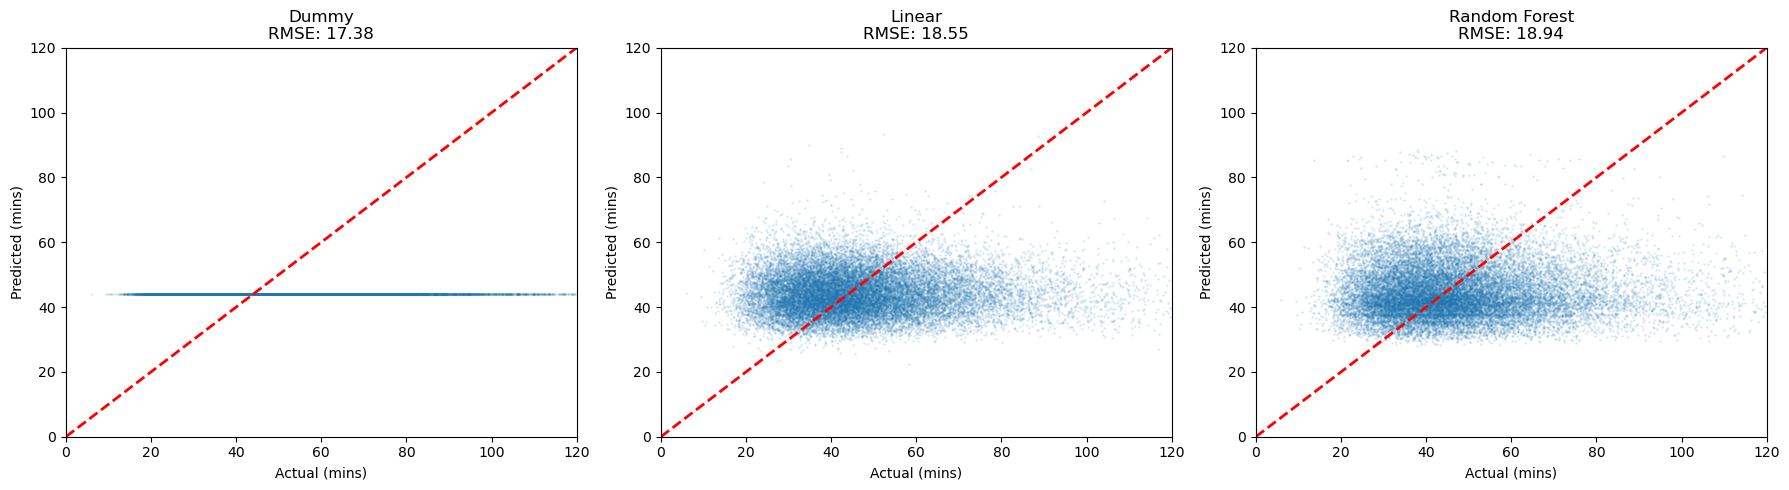

Error Analysis (Predicted - Actual):

Dummy:
  Mean error:   -3.19 mins
  Median error: -0.25 mins
  Errors within ±10 mins: 49.1%
  Errors within ±15 mins: 67.9%

Linear:
  Mean error:   -2.68 mins
  Median error: -0.33 mins
  Errors within ±10 mins: 45.8%
  Errors within ±15 mins: 63.5%

Random Forest:
  Mean error:   -2.53 mins
  Median error: -0.36 mins
  Errors within ±10 mins: 44.9%
  Errors within ±15 mins: 62.2%


In [6]:
# Deeper evaluation — where are models winning and losing?
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

models = {
    'Dummy': np.expm1(y_pred_dummy),
    'Linear': np.expm1(y_pred_lr), 
    'Random Forest': np.expm1(y_pred_rf)
}

for ax, (name, preds) in zip(axes, models.items()):
    ax.scatter(y_val_raw, preds, alpha=0.1, s=1)
    ax.plot([0, 120], [0, 120], 'r--', linewidth=2)
    ax.set_xlabel('Actual (mins)')
    ax.set_ylabel('Predicted (mins)')
    ax.set_title(f'{name}\nRMSE: {np.sqrt(mean_squared_error(y_val_raw, preds)):.2f}')
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 120)

plt.tight_layout()
plt.show()

# Error distribution
print("Error Analysis (Predicted - Actual):")
for name, preds in models.items():
    errors = preds - y_val_raw
    print(f"\n{name}:")
    print(f"  Mean error:   {errors.mean():.2f} mins")
    print(f"  Median error: {errors.median():.2f} mins")
    print(f"  Errors within ±10 mins: "
          f"{(errors.abs() <= 10).mean()*100:.1f}%")
    print(f"  Errors within ±15 mins: "
          f"{(errors.abs() <= 15).mean()*100:.1f}%")

#### Reading the Scatter Plots

**Dummy** — flat horizontal line at 43.9. Exactly what we expected. No learning at all.

**Linear** — cloud of points, vaguely diagonal but extremely scattered. Some learning but massive variance.

**Random Forest** — the cloud is noticeably tighter around the diagonal in the 30-60 minute range. It's actually learning the middle of the distribution reasonably well. But it struggles badly at the 

##### The Honest Baseline Summary

RMSE told us Random Forest was worst. But operationally all three are remarkably similar — within 2-4% of each other on what actually matters.

This is a **hard regression problem.** With max correlation of 0.31 and high natural variance in delivery times, no model will achieve dramatic accuracy. The signal in our features simply has a ceiling.

```
Dummy:         RMSE 17.38, ±10min: 49.1%  ← floor to beat
Random Forest: RMSE 18.94, ±10min: 44.9%  ← best structural learner
Linear:        RMSE 18.55, ±10min: 45.8%  ← linear relationships insufficient

Our Neural Network target:
  RMSE < 17.38 (must beat dummy)
  ±10 min accuracy > 50% (meaningful improvement)
```

Beating dummy by even 1-2 RMSE points on this dataset would be a genuine achievement given the signal ceiling.

### Module 7 Complete ✅

Baselines established. Every future model result now has meaning. We know:

The problem is genuinely hard — max feature correlation 0.31 limits any model. Linear relationships are insufficient — confirmed by linear regression losing to dummy. Non-linear patterns exist — Random Forest found them (demand_supply_ratio dominates at 49.6% importance). Our neural network needs to learn complex feature interactions to win.

#### Notes
We're using fixed/default parameters intentionally for baselines. The purpose of Module 7 is not to build the best possible Random Forest — it's to establish a **reference point** with reasonable defaults. Tuning baselines defeats the purpose.

Think of it this way — baselines answer "what can a reasonable model do without effort?" Tuning answers "what's the ceiling for this model family?" We'll tune our neural network in Module 9. Baselines stay simple.

## Module 8 — Building the Neural Network

This is what everything has been building toward. We'll design the architecture thoughtfully — not copy-paste a standard template but make deliberate choices about:

**Input layer** — how many neurons and why

**Hidden layers** — how deep, how wide, and what activation functions

**Output layer** — regression output, why no activation function here

**Loss function** — MSE vs MAE vs Huber, which suits our problem

**Optimizer** — Adam and why it's the right choice here

**Batch normalization and Dropout** — preventing overfitting from day one

Every choice will have a reason grounded in what we learned in Modules 1-7.